In [1]:
!python -V

Python 3.7.10


In [2]:
# Import basic python packages you will need to run this script
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy
from imageio import imread

import skimage.io as io
import skimage.transform as trans
import cv2 as cv

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pb183/opt/anaconda3/envs/py37/lib

In [3]:
# added plaidML setup code for using AMD Radeon GPU on the iMac
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [4]:
# import all the important loss, model, optimizing functions and more from tensorflow w/keras backend
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

import keras
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from keras.layers.noise import GaussianDropout

In [6]:
# direct to the appropriate directory where you images an ground truth masks lives
shared_path = '/Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/' 
image_path = shared_path+'Training_bitmaps/' 
mask_path = shared_path+'Training_masks/' 

# new folder path for test images if you want to use a separate folder for test images
testset_path = shared_path        
testimage_path = testset_path+'Validation_bitmaps/'       
testmask_path = testset_path+'Validation_masks/'     

In [7]:
# this looks for all files in the image and mask paths that are bitmpap files and saves their filenames in these arrays
included_extensions = ['bmp']
file_names_images = [fn for fn in os.listdir(image_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names_masks = [fn for fn in os.listdir(mask_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names_testimages = [fn for fn in os.listdir(testimage_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

file_names_testmasks = [fn for fn in os.listdir(testmask_path)
              if any(fn.endswith(ext) for ext in included_extensions)]

In [8]:
# this is just a check to make sure that the number of images and masks match up
print(len(file_names_images))
print(len(file_names_masks))
print(len(file_names_testimages))
print(len(file_names_testmasks))

840
840
360
360


In [9]:
# define size of images and starting positions for cropping 
images = np.zeros((len(file_names_images),size,size, 1)).astype('float')
testimages = np.zeros((len(file_names_testimages),size,size, 1)).astype('float')
starty = 160
cropx = 256
cropy = 256
startx = 130

# import bitmap images into arrays
for i in range(len(file_names_images)):
    image = imread(image_path+file_names_images[i], as_gray=True)/255
    image = image[starty:starty+cropy,startx:startx+cropx]
    image = image[..., None] # adds a channel layer
    images[i] = image # adds subsequent image arrays to img matrix

# import test bitmap images into arrays
for i in range(len(file_names_testimages)):
    testimage = imread(testimage_path+file_names_testimages[i], as_gray=True)/255
    testimage = testimage[starty:starty+cropy,startx:startx+cropx]
    testimage = testimage[..., None] # adds a channel layer
    testimages[i] = testimage # adds subsequent image arrays to img matrix

# verify number of images and shape
print(images.shape)
print(testimages.shape)

(840, 256, 256, 1)
(360, 256, 256, 1)


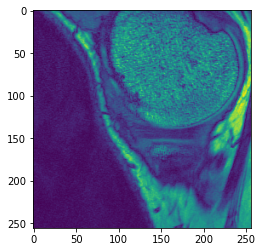

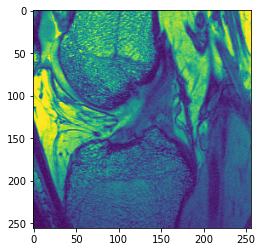

In [10]:
# display a sample image from images array
plt.imshow(np.sum(images[90],axis=2))
plt.show()
plt.imshow(np.sum(testimages[1],axis=2))


(840, 256, 256, 1)
(360, 256, 256, 1)


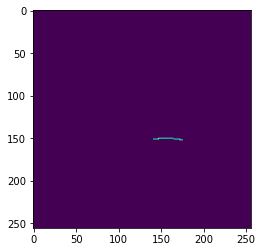

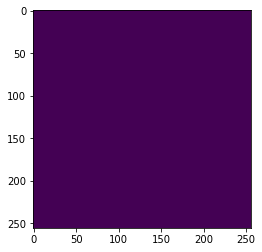

In [11]:
# import ground truth masks into arrays
mask = np.zeros((len(file_names_images), size, size, 1)).astype('float')
for i in range(len(file_names_images)):
    segmask = imread(mask_path+file_names_masks[i], as_gray=True)/255
    minimum = segmask.min()
    segmask = np.where(segmask==minimum, 0, 1)
    segmask = segmask[starty:starty+cropy,startx:startx+cropx]
    segmask = segmask[..., None]
    mask[i] = segmask # adds subsequent image arrays to img matrix
    
# import test ground truth masks into arrays
testmask = np.zeros((len(file_names_testmasks), size, size, 1)).astype('float')
for i in range(len(file_names_testmasks)):
    testsegmask = imread(testmask_path+file_names_testmasks[i], as_gray=True)/255
    testminimum = testsegmask.min()
    testsegmask = np.where(testsegmask==minimum, 0, 1)
    testsegmask = testsegmask[starty:starty+cropy,startx:startx+cropx]
    testsegmask = testsegmask[..., None]
    testmask[i] = testsegmask # adds subsequent image arrays to img matrix

# verify number of images and shape
print(mask.shape)
print(testmask.shape)
plt.imshow(np.sum(mask[90],axis=2))
plt.show()
plt.imshow(np.sum(testmask[1],axis=2))

In [12]:
# these are functions for pairing the image to its respective mask
def get_dataset(images, mask, batch_size):
    dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(images, dtype=tf.float32)) #converts to tf type
    dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32)) #converts to tf type

    dataset_input = dataset_input.map(lambda x: tf.image.per_image_standardization(x)) #standardizes the image
    dataset_input = dataset_input.map(lambda x: tf.image.adjust_contrast(x,1.2)) #adds some contrast

    dataset = tf.data.Dataset.zip((dataset_input, dataset_mask)) #pairs the images to the masks into one tf array
    dataset = dataset.shuffle(len(images)).repeat() #randomly shuffles dataset and repeats the dataset
    dataset = dataset.batch(batch_size).prefetch(batch_size) # set the batch size
    print('image shape: ', dataset.output_shapes[0])
    print('label shape: ', dataset.output_shapes[1])
    print('types: ', dataset.output_types)
    print()
    print(dataset)
    return dataset

#this does the same as get_dataset but does not shuffle the images. used for displaying results
def get_dataset_noshuffle(images, mask, batch_size):
    dataset_input = tf.data.Dataset.from_tensor_slices(tf.constant(images, dtype=tf.float32))
    dataset_mask = tf.data.Dataset.from_tensor_slices(tf.constant(mask, dtype=tf.float32))

    dataset_input = dataset_input.map(lambda x: tf.image.per_image_standardization(x))
    dataset_input = dataset_input.map(lambda x: tf.image.adjust_contrast(x,1.2))

    dataset = tf.data.Dataset.zip((dataset_input, dataset_mask))
    dataset = dataset.batch(batch_size).prefetch(batch_size)
    print('image shape: ', dataset.output_shapes[0])
    print('label shape: ', dataset.output_shapes[1])
    print('types: ', dataset.output_types)
    print()
    print(dataset)
    return dataset

In [13]:
# randomly splits the whole dataset into a training and test set. change the test_size to a different value between 0 and 1 to make it smaller/bigger
X_train, X_test, y_train, y_test = train_test_split(images, mask, test_size=0.0001, random_state=42)
X_test = testimages 
y_test = testmask 

In [14]:
print(X_train.shape)
print(X_test.shape)

(839, 256, 256, 1)
(360, 256, 256, 1)


In [15]:
# use the get_dataset function to pair the X_train with y_train and X_test with y_test. 
train_dataset = get_dataset(X_train, y_train, 16)
test_dataset = get_dataset(X_test, y_test, 4)
test_dataset_noshuffle = get_dataset_noshuffle(X_test, y_test, 4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
image shape:  (?, 256, 256, 1)
label shape:  (?, 256, 256, 1)
types:  (tf.float32, tf.float32)

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?, 256, 256, 1)), types: (tf.float32, tf.float32)>
image shape:  (?, 256, 256, 1)
label shape:  (?, 256, 256, 1)
types:  (tf.float32, tf.float32)

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?, 256, 256, 1)), types: (tf.float32, tf.float32)>
image shape:  (?, 256, 256, 1)
label shape:  (?, 256, 256, 1)
types:  (tf.float32, tf.float32)

<DatasetV1Adapter shapes: ((?, 256, 256, 1), (?, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [16]:
smooth = 1.
dropout_rate = 0.5
act = 'relu'

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [17]:
# following unet model is from https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights = None,input_size = (size,size,1), df=8, kernel_size = 5): #modify input image size here
    inputs = Input(input_size)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(df*2*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(df*2*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3) 
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(df*2*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(df*2*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(df*2*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(df*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(df*2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(df, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(df, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = ['accuracy','binary_accuracy', 'mae',
                            tf.keras.metrics.Precision(name='precision'), dice_coef,
                            tf.keras.metrics.FalseNegatives(thresholds=0.5, name='FN', dtype=None),
                            tf.keras.metrics.FalsePositives(thresholds=0.5, name='FP', dtype=None),
                            tf.keras.metrics.TrueNegatives(thresholds=0.5, name='TN', dtype=None),
                            tf.keras.metrics.TruePositives(thresholds=0.5, name='TP', dtype=None)])
    
    model.summary() #if you want to printout all the parameters and model summary 

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [18]:
# run the actual unet function
model = unet(pretrained_weights=None, df=8, input_size=(size, size, 1), kernel_size=5)
y = model.count_params() # counts the number of aparameters in the model you just created with the specs you defined

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  208         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  1608        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
x = len(X_train)*size*size # counting all the number of pixels in the entire training image set
x/y 

43.275244946996686

In [20]:
batch_size = 16
batch_size_test = 4 #don't need a large batch size for the test set
steps_epoch = np.int16(np.ceil(len(X_train)/batch_size)) # determines your steps per epoch
steps_val = np.int16(np.ceil(len(X_test)/batch_size_test)) # determines your steps for the test set

In [21]:
# update the file name for the saved weights files
model_checkpoint = ModelCheckpoint('Cart_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5', monitor='loss',
                                   verbose=1, save_best_only=True)

#This is the actual training part of the code
history = model.fit(train_dataset, validation_data=test_dataset, steps_per_epoch=steps_epoch, 
                    validation_steps=steps_val, batch_size=batch_size, epochs=15, verbose=1, callbacks=[model_checkpoint])

Epoch 1/15
52/53 [============================>.] - ETA: 4s - loss: 0.9672 - acc: 0.9784 - binary_accuracy: 0.9784 - mean_absolute_error: 0.0789 - precision: 0.0011 - dice_coef: 0.0328 - FN: 49316.0000 - FP: 1131149.0000 - TN: 53344232.0000 - TP: 1262.0000
Epoch 00001: loss improved from inf to 0.96527, saving model to Cart_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5
53/53 [==============================] - 303s 6s/step - loss: 0.9653 - acc: 0.9787 - binary_accuracy: 0.9787 - mean_absolute_error: 0.0774 - precision: 0.0011 - dice_coef: 0.0347 - FN: 50242.0000 - FP: 1131209.0000 - TN: 54391824.0000 - TP: 1262.0000 - val_loss: 0.9130 - val_acc: 0.9990 - val_binary_accuracy: 0.9990 - val_mean_absolute_error: 0.0018 - val_precision: 0.0000e+00 - val_dice_coef: 0.0870 - val_FN: 21907.0000 - val_FP: 811.0000 - val_TN: 23570244.0000 - val_TP: 0.0000e+00
Epoch 2/15
52/53 [============================>.] - ETA: 4s - loss: 0.8751 - acc: 0.9974 - binary_accuracy: 0.9974 - mean_ab

53/53 [==============================] - 278s 5s/step - loss: 0.6109 - acc: 0.9990 - binary_accuracy: 0.9990 - mean_absolute_error: 0.0011 - precision: 0.4744 - dice_coef: 0.3891 - FN: 18977.0000 - FP: 37192.0000 - TN: 55484776.0000 - TP: 33574.0000 - val_loss: 0.7260 - val_acc: 0.9986 - val_binary_accuracy: 0.9986 - val_mean_absolute_error: 0.0013 - val_precision: 0.3131 - val_dice_coef: 0.2740 - val_FN: 12743.0000 - val_FP: 20103.0000 - val_TN: 23550950.0000 - val_TP: 9164.0000
Epoch 11/15
52/53 [============================>.] - ETA: 4s - loss: 0.6044 - acc: 0.9990 - binary_accuracy: 0.9990 - mean_absolute_error: 0.0011 - precision: 0.4754 - dice_coef: 0.3956 - FN: 17766.0000 - FP: 36717.0000 - TN: 54438200.0000 - TP: 33275.0000
Epoch 00011: loss improved from 0.61095 to 0.60242, saving model to Cart_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5
53/53 [==============================] - 280s 5s/step - loss: 0.6024 - acc: 0.9990 - binary_accuracy: 0.9990 - mean_absolute

In [22]:
# copy and paste the weights hdf5 file that had the best accuracy and lowest loss. apply trained weights to validation data
model.load_weights('Cart_weights_df8_trainbatch16_testbatch4_ep15_dice_coef_loss.hdf5')
results = model.predict(test_dataset_noshuffle, batch_size=batch_size_test, verbose=1, steps=steps_val)

90/90 [==============================] - 43s 475ms/step


In [23]:
# this is just a function to display a bunch of images in small tiles
def plot_examples(batch):
    plt.figure(figsize=(15, 15))
    for i in range(len(batch)):
        plt.subplot(12, 8, i+1)
        plt.imshow(batch[i])
#         plt.colorbar()
#         plt.axis('off')
        plt.gray()
    plt.show()

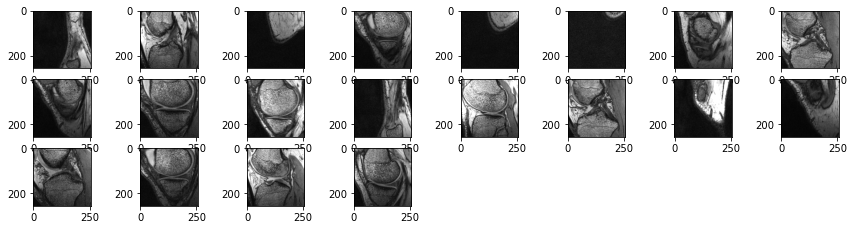

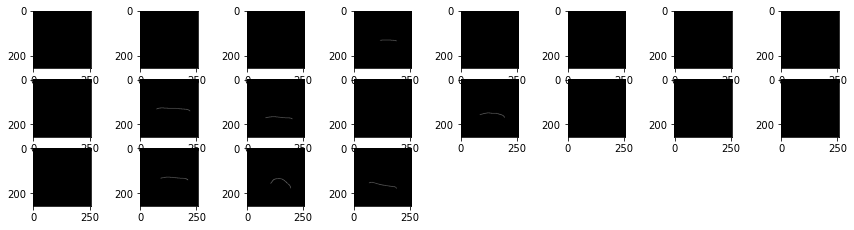

In [24]:
plot_examples(np.sum(X_test[0:20],axis=3)) # display the test images
plot_examples(np.sum(y_test[0:20],axis=3)) # display the test masks

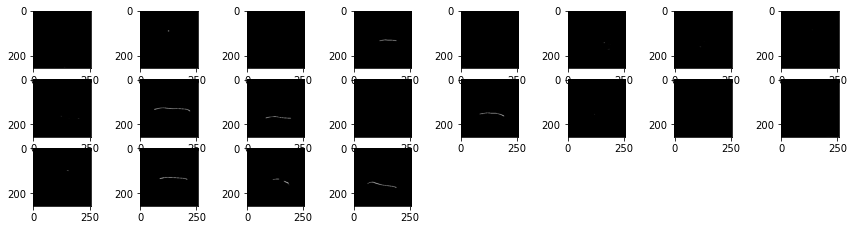

In [25]:
plot_examples(np.sum(results[0:20], axis=3)) # display how the model predicted the masks

In [26]:
# threshold images to have pixel values of 0 or 1 (everything above the threshold_val becomes 1 for bone)
results.shape
#results_thresh = np.zeros((len(results), size, size, 1)).astype('float')
results_thresh = results
threshold_val = 0.5 # change this as needed
threshold_indices_1 = results_thresh > threshold_val
threshold_indices_0 = results_thresh <= threshold_val
results_thresh[threshold_indices_1] = 1
results_thresh[threshold_indices_0] = 0

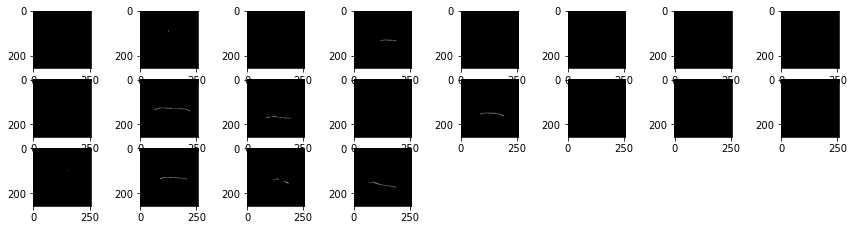

In [27]:
plot_examples(np.sum(results_thresh[0:20], axis=3)) # display thresholded images

In [28]:
# create a new results folder
results_path = testimage_path+'Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss' 
os.mkdir(results_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


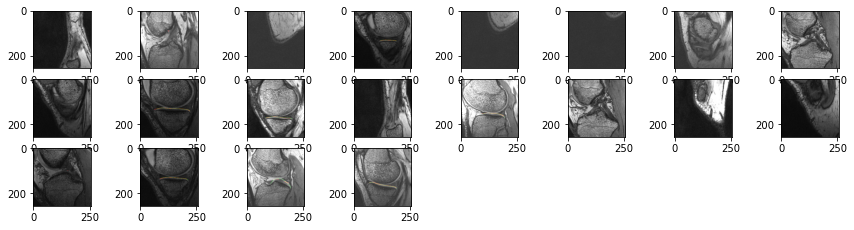

In [29]:
# convert all results, y_test, X_test arrays into 3 channel arrays
all_combined = np.zeros((len(results), size, size, 3)).astype('float') #initialize matrix first

# combines the result, y_test, X_test overlaid into one image
for i in range(len(results)):
    results_y_test = np.concatenate((results_thresh[i], y_test[i], np.zeros((256,256,1))), axis=2)
#     results_y_test_comb[i] = results_y_test
    X_test_3 = np.concatenate((X_test[i],X_test[i],X_test[i]), axis=2)
#     X_test_3_comb[i] = X_test_3
    combined = cv.addWeighted(results_y_test, 0.5, X_test_3, 1, 0) #combine  test mask, predicted mask, MRI
    all_combined[i] = combined

plot_examples(all_combined[0:20]) # display combined images

In [30]:
# zero padding to convert 256x256 results to 512x512
full_size = 512
print(results.shape)
results_512 = np.pad(results, [(0,0),(starty,full_size-(starty+cropy)),
                                      (startx,full_size-(startx+cropx)),(0,0)], mode='constant', constant_values=0)
results_thresh_512 = np.pad(results_thresh, [(0,0),(starty,full_size-(starty+cropy)),
                                      (startx,full_size-(startx+cropx)),(0,0)], mode='constant', constant_values=0)
print(results_512.shape)

(360, 256, 256, 1)
(360, 512, 512, 1)


In [31]:
# save all images in the new results folder. change the file names as you see fit but they are currently set up to keep their same original file name to ensure you're saving the right subject and slice

for i in range(len(results_thresh)):
    io.imsave(os.path.join(results_path, 'predictedmask.'+file_names_testimages[i]), results[i])
    io.imsave(os.path.join(results_path, 'predictedmask_thresh_512.'+file_names_testimages[i]), results_thresh_512[i])
    io.imsave(os.path.join(results_path, 'predictedmask_y_test_MRI.'+file_names_testimages[i]), all_combined[i])
    io.imsave(os.path.join(results_path, 'X_test.'+file_names_testimages[i]), X_test[i])
    io.imsave(os.path.join(results_path, 'y_test.'+file_names_testimages[i]), y_test[i])

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0115.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0115.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.69F025D20LtPre-0003.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0003.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8.

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0031.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0031.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0021.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0021.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.69F025D20LtPre-0107.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0107.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8.

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0111.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0111.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0112.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0112.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0036.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0036.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0086.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0086.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0028.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0028.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.69F025D20LtPre-0001.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0001.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8.

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.69F025D20LtPre-0002.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0002.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8.

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0085.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0085.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0114.bmp is a low contrast image
  after removing the cwd from sys.path.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0114.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

Lossy conversion from float64 to uint8. Range [0.04313725605607033, 1.2960784435272217]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0037.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedma

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04313725605607033, 1.029411792755127]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0027.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0093.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.69F025D20LtPre-0004.bmp is a 

Lossy conversion from float64 to uint8. Range [0.16862745583057404, 1.1196078658103943]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0067.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predicte

Lossy conversion from float64 to uint8. Range [0.1725490242242813, 1.3392156958580017]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0048.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predicted

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0114.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0051.bmp is a low 

Lossy conversion from float64 to uint8. Range [0.0470588244497776, 1.4882352948188782]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0092.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmas

Lossy conversion from float64 to uint8. Range [0.0235294122248888, 1.0215686559677124]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0102.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedm

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0069.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0108.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0010.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0107.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0016.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Vali

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0117.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validat

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03921568766236305, 1.358823537826538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0076.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0070.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validat

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16862745583057404, 1.1901960968971252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0074.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Brad

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0120.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0039.bmp is a lo

Lossy conversion from float64 to uint8. Range [0.04313725605607033, 1.3666666746139526]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0047.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedma

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0050.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.03921568766236305, 1.1745098233222961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0103.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0105.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

Lossy conversion from float64 to uint8. Range [0.04313725605607033, 1.315686285495758]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0046.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmas

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0118.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0116.bmp is a lo

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0020.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0044.bmp is a low 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0060.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0017.bmp is a low 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0031.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0009.bmp is a low 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0072.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0100.bmp is a low 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0074.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.CSACL070RTPre-0017.bmp is a lo

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0093.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0032.bmp is a low 

Lossy conversion from float64 to uint8. Range [0.03921568766236305, 1.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0088.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.69F025D20LtP

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0106.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask.BMI018RTpre-0052.bmp is a low

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-0065.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Vali

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-0097.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Valid

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_y_test_MRI.69F025D20LtPre-0007.bmp is a low contrast image
  
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/X_test.69F025D20LtPre-0007.bmp is a low contrast image
  import sys
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_l

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0080.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.05098039284348488, 1.229411780834198]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_c

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0089.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0470588244497776, 1.484313726425171]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/Def

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0067.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0045.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0008.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0008.b

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0034.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0020.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0091.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0116.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0116.b

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0008.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0118.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0118.b

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0082.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.04313725605607033, 1.2490196228027344]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0061.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0047.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0078.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16862745583057404, 1.1235294342041016]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_di

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0093.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0470588244497776, 1.4803921580314636]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_c

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0031.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16862745583057404, 1.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0020.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0097.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.69F025D20LtPre-

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0006.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0006.b

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.BMI018RTpre-0002.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.BMI018RTpre-0002.b

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0071.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16862745583057404, 1.1392157077789307]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_di

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.CSACL070RTPre-0059.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_test.CSACL070RTPre-00

/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/predictedmask_thresh_512.69F025D20LtPre-0036.bmp is a low contrast image
  """
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.16862745583057404, 1.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/Users/pb183/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: /Volumes/dusom_ortho_research/Private/DefratePrivate/Bradley/ML/ML_FINAL_PROJ/DATA_Cart/Validation_bitmaps/Cart_Results_df8_trainbatch16_testbatch4_ep15_dice_coef_loss/y_

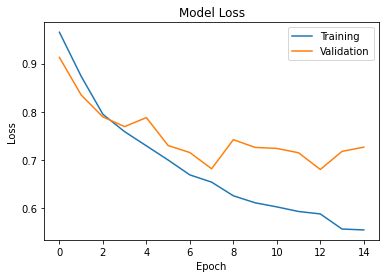

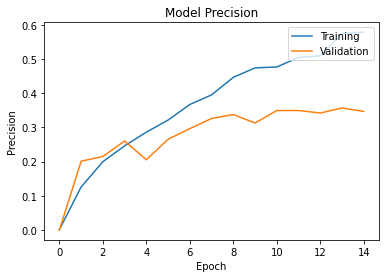

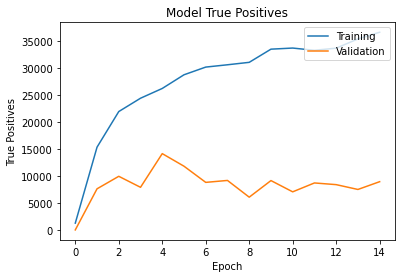

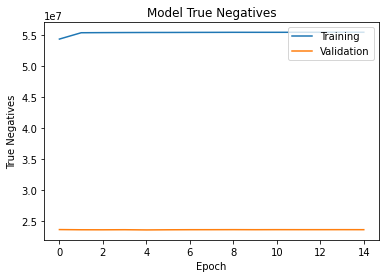

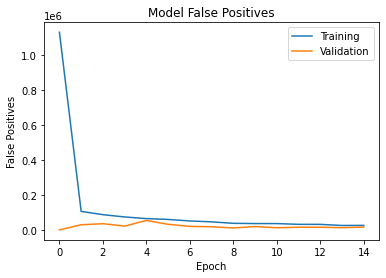

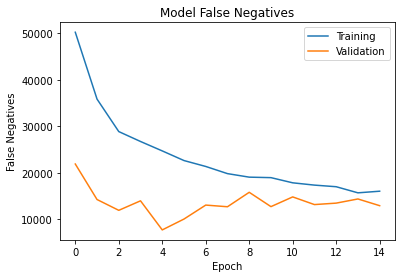

In [32]:
# Create a save a plot of the training and validation loss

os.chdir(results_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('Loss_per_epoch_plot.png')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('Precision_per_epoch_plot.png')
plt.show()

plt.plot(history.history['TP'])
plt.plot(history.history['val_TP'])
plt.title('Model True Positives')
plt.ylabel('True Positives')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('True_positives_per_epoch_plot.png')
plt.show()

plt.plot(history.history['TN'])
plt.plot(history.history['val_TN'])
plt.title('Model True Negatives')
plt.ylabel('True Negatives')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('True_negatives_per_epoch_plot.png')
plt.show()

plt.plot(history.history['FP'])
plt.plot(history.history['val_FP'])
plt.title('Model False Positives')
plt.ylabel('False Positives')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('False_positives_per_epoch_plot.png')
plt.show()

plt.plot(history.history['FN'])
plt.plot(history.history['val_FN'])
plt.title('Model False Negatives')
plt.ylabel('False Negatives')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.savefig('False_negatives_per_epoch_plot.png')
plt.show()


In [33]:
# Find which epoch had the lowest training and validation losses

loss_training_history = history.history['loss']
loss_val_history = history.history['val_loss']

min_training_loss = np.min(loss_training_history)
best_training_epoch = loss_training_history.index(min_training_loss) +1
print('Training Epoch with Lowest Loss = ', best_training_epoch)
print('Training Loss Value = ', min_training_loss)

min_val_loss = np.min(loss_val_history)
best_val_epoch = loss_val_history.index(min_val_loss) +1
print('Validation Epoch with Lowest Loss = ', best_val_epoch)
print('Validation Loss Value = ', min_val_loss)

Training Epoch with Lowest Loss =  15
Training Loss Value =  0.5545676912901536
Validation Epoch with Lowest Loss =  13
Validation Loss Value =  0.6800938626130422


In [1]:
# Find which epoch had the lowest training and validation precision

precision_training_history = history.history['precision']
precision_val_history = history.history['val_precision']

max_training_precision = np.max(precision_training_history)
best_training_epoch = precision_training_history.index(max_training_precision) +1
print('Training Epoch with Best Precision = ', best_training_epoch)
print('Training Precision Value = ', max_training_precision)

max_val_precision = np.max(precision_val_history)
best_val_epoch = precision_val_history.index(max_val_precision) +1
print('Val Epoch with Best Precision = ', best_val_epoch)
print('Val Precision Value = ', max_val_precision)

NameError: name 'history' is not defined